In [1]:
import json
with open('ebird_config.json') as f:
    data = json.load(f)
    recent_species_observations = data['recent_species_observations']
    ebird_token = data['ebird_token']
    gmap_api_key = data['gmap_api_key']
# recent_species_observations

In [2]:
import requests
headers = {}
headers['X-eBirdApiToken'] = ebird_token
response = requests.get(recent_species_observations, headers=headers)
res_json = response.json()

In [3]:
# res_json

In [4]:
import datetime as dt
import collections as col
# some observation date has no HH:MM part, just dates
DATE_FORMAT = '%Y-%m-%d'
Sighting = col.namedtuple('Sighting', ['lat', 'lng', 'date'])
# 0-th is today, 1-st is yesterday, etc
sightings = list()
for sighting in res_json:
    sightings.append(Sighting(lat=sighting['lat'], lng=sighting['lng'],
                              date=dt.datetime.strptime(sighting['obsDt'][:10], DATE_FORMAT)))
today = dt.date.today()
sightings_last_seven_days = list() # today is included
for i in range(0, 7):
    sightings_last_seven_days.append(
        list(filter(lambda s: s.date.date() == today - dt.timedelta(days=i), sightings)))
#sightings_last_seven_days

In [5]:
layers = list()
# colors of the rainbow, the more red the color, the closer to today
# some color strings like 'orange' is not accepted by gmaps
colors = list(['red', 'rgb(255, 165, 0)', 'yellow', 'green', 'blue', 'rgb(75, 0, 130)', 'rgb(238, 130, 238)'])
for day_sightings in sightings_last_seven_days:
    layers.append(list(map(lambda s: (s.lat, s.lng), day_sightings)))

In [8]:
import gmaps
gmaps.configure(api_key=gmap_api_key)
fig = gmaps.figure()
def add_layer(lat_lng, color, scale):
    layer = gmaps.symbol_layer(lat_lng, fill_color=color, stroke_color=color, scale=scale)
    fig.add_layer(layer)
# not counting today, used to further limit the 7 days to a smaller number of days, if desired
#days_back = int(input('Number of days to show, 0 for today only '))
days_back = 2
days_back = max(0, days_back)
# add the layers backwards so today is on top, but it does not seem to work,
# looks like there is no support for setting zIndex on a symbol (or symbols of a layer)
for i in range(min(days_back, 6), -1, -1):
    add_layer(layers[i], colors[i], 2)
    # this line changes the size of the dots according to how recent they are
    #add_layer(layers[i], colors[i], (4 - i) if (days_back <= 3) else int((8-i)/2))
#fig

Figure(layout=FigureLayout(height='420px'))

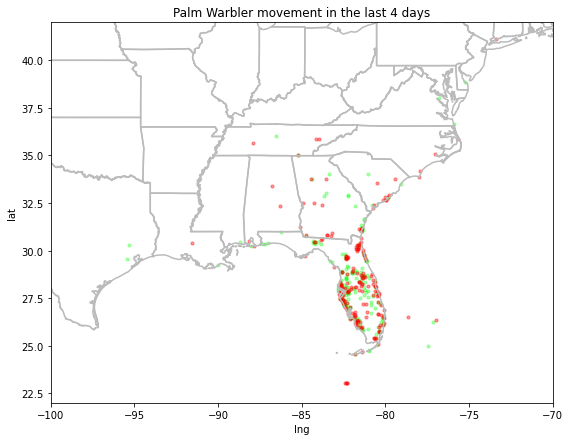

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
fig = plt.figure(figsize=(9, 7))
plt.xlim(-100, -70)
plt.ylim(22, 42)
yesterday = np.array(layers[1])
two_days_ago = np.array(layers[2])
# paint the days fatheraway first, so it is at the bottom
df1 = pd.DataFrame(two_days_ago, columns=['lat', 'lng'])
df1.plot('lng', 'lat', ax=fig.axes[0], kind='scatter', c="#00ff00", s=10, alpha=0.3)
df = pd.DataFrame(yesterday, columns=['lat', 'lng'])
df.plot('lng', 'lat', ax=fig.axes[0], kind='scatter', c="#ff0000", s=10, alpha=0.4)
states = gp.read_file('../data/geo/us-census/cb_2018_us_state_5m.shp')
states.boundary.plot(ax=fig.axes[0], color='#bbbbbb')
plural = 's' if days_back > 1 else ''
plt.title(f"Palm Warbler movement in the last {days_back} day{plural}")
plt.show()